# Visualize a scikit-learn pipeline

Pipeline can be big with *scikit-learn*, let's dig into a visual way to look a them.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.simplefilter("ignore")

## Simple model

Let's vizualize a simple pipeline, a single model not even trained.

In [4]:
import pandas
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

iris = datasets.load_iris()
X = iris.data[:, :4]
df = pandas.DataFrame(X)
df.columns = ["X1", "X2", "X3", "X4"]
clf = LogisticRegression()
clf

LogisticRegression()

The trick consists in converting the pipeline in a graph through the [DOT](https://en.wikipedia.org/wiki/DOT_(graph_description_language)) language.

In [5]:
from mlinsights.plotting import pipeline2dot
dot = pipeline2dot(clf, df)
print(dot)

digraph{
  orientation=portrait;
  nodesep=0.05;
  ranksep=0.25;
  sch0[label="<f0> X1|<f1> X2|<f2> X3|<f3> X4",shape=record,fontsize=8];

  node1[label="union",shape=box,style="filled,rounded",color=cyan,fontsize=12];
  sch0:f0 -> node1;
  sch0:f1 -> node1;
  sch0:f2 -> node1;
  sch0:f3 -> node1;
  sch1[label="<f0> -v-0",shape=record,fontsize=8];
  node1 -> sch1:f0;

  node2[label="LogisticRegression",shape=box,style="filled,rounded",color=yellow,fontsize=12];
  sch1:f0 -> node2;
  sch2[label="<f0> PredictedLabel|<f1> Probabilities",shape=record,fontsize=8];
  node2 -> sch2:f0;
  node2 -> sch2:f1;
}


It is lot better with an image.

In [6]:
dot_file = "graph.dot"
with open(dot_file, "w", encoding="utf-8") as f:
    f.write(dot)

In [7]:
# might be needed on windows
import sys
import os
if sys.platform.startswith("win") and "Graphviz" not in os.environ["PATH"]:
    os.environ['PATH'] = os.environ['PATH'] + r';C:\Program Files (x86)\Graphviz2.38\bin'

In [8]:
from pyquickhelper.loghelper import run_cmd
cmd = "dot -G=300 -Tpng {0} -o{0}.png".format(dot_file)
run_cmd(cmd, wait=True, fLOG=print);

[run_cmd] execute dot -G=300 -Tpng graph.dot -ograph.dot.png
end of execution dot -G=300 -Tpng graph.dot -ograph.dot.png


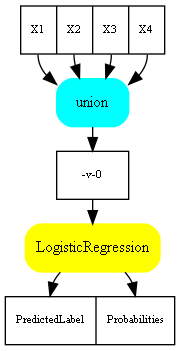

In [9]:
from PIL import Image
img = Image.open("graph.dot.png")
img

## Complex pipeline

*scikit-learn* instroduced a couple of transform to play with features in a single pipeline. The following example is taken from [Column Transformer with Mixed Types](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py).

In [10]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [11]:
columns = ['pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare',
           'cabin', 'embarked', 'boat', 'body', 'home.dest']

numeric_features = ['age', 'fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['embarked', 'sex', 'pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='lbfgs'))])
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncod

Let's see it first as a simplified text.

In [12]:
from mlinsights.plotting import pipeline2str
print(pipeline2str(clf))

Pipeline
   ColumnTransformer
      Pipeline(age,fare)
         SimpleImputer
         StandardScaler
      Pipeline(embarked,sex,pclass)
         SimpleImputer
         OneHotEncoder
   LogisticRegression


In [13]:
dot = pipeline2dot(clf, columns)

In [14]:
dot_file = "graph2.dot"
with open(dot_file, "w", encoding="utf-8") as f:
    f.write(dot)

In [15]:
cmd = "dot -G=300 -Tpng {0} -o{0}.png".format(dot_file)
run_cmd(cmd, wait=True, fLOG=print);

[run_cmd] execute dot -G=300 -Tpng graph2.dot -ograph2.dot.png
end of execution dot -G=300 -Tpng graph2.dot -ograph2.dot.png


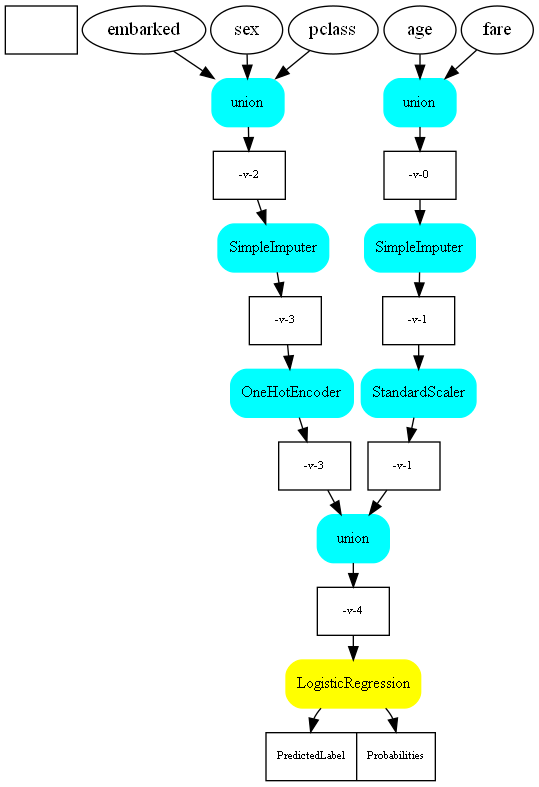

In [16]:
img = Image.open("graph2.dot.png")
img

## With javascript

In [17]:
from jyquickhelper import RenderJsDot
RenderJsDot(dot)

## Example with FeatureUnion

In [18]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

model = Pipeline([('poly', PolynomialFeatures()),
                          ('union', FeatureUnion([
                                        ('scaler2', MinMaxScaler()),
                                        ('scaler3', StandardScaler())]))])
dot = pipeline2dot(model, columns)
RenderJsDot(dot)

## Compute intermediate outputs

It is difficult to access intermediate outputs with *scikit-learn* but it may be interesting to do so. The method [alter_pipeline_for_debugging](find://alter_pipeline_for_debugging) modifies the pipeline to intercept intermediate outputs.

In [19]:
from numpy.random import randn

model = Pipeline([('scaler1', StandardScaler()),
                  ('union', FeatureUnion([
                      ('scaler2', StandardScaler()),
                      ('scaler3', MinMaxScaler())])),
                  ('lr', LinearRegression())])

X = randn(4, 5)
y = randn(4)
model.fit(X, y)

Pipeline(steps=[('scaler1', StandardScaler()),
                ('union',
                 FeatureUnion(transformer_list=[('scaler2', StandardScaler()),
                                                ('scaler3', MinMaxScaler())])),
                ('lr', LinearRegression())])

In [20]:
print(pipeline2str(model))

Pipeline
   StandardScaler
   FeatureUnion
      StandardScaler
      MinMaxScaler
   LinearRegression


Let's now modify the pipeline to get the intermediate outputs.

In [21]:
from mlinsights.helpers.pipeline import alter_pipeline_for_debugging
alter_pipeline_for_debugging(model)

The function adds a member ``_debug`` which stores inputs and outputs in every piece of the pipeline.

In [22]:
model.steps[0][1]._debug

BaseEstimatorDebugInformation(StandardScaler)

In [23]:
model.predict(X)

array([ 0.73619378,  0.87936142, -0.56528874, -0.2675163 ])

The member was populated with inputs and outputs.

In [24]:
model.steps[0][1]._debug

BaseEstimatorDebugInformation(StandardScaler)
  transform(
   shape=(4, 5) type=<class 'numpy.ndarray'>
   [[ 1.22836841  2.35164607 -0.37367786  0.61490475 -0.45377634]
    [-0.77187962  0.43540786  0.20465106  0.8910651  -0.23104796]
    [-0.36750208  0.35154324  1.78609517 -1.59325463  1.51595267]
    [ 1.37547609  1.59470748 -0.5932628   0.57822003  0.56034736]]
  ) -> (
   shape=(4, 5) type=<class 'numpy.ndarray'>
   [[ 0.90946066  1.4000516  -0.67682808  0.49311806 -1.03765861]
    [-1.20030006 -0.89626498 -0.05514595  0.76980985 -0.7493565 ]
    [-0.77378303 -0.99676381  1.64484777 -1.71929067  1.51198065]
    [ 1.06462242  0.49297719 -0.91287374  0.45636275  0.27503446]]
  )

Every piece behaves the same way.

In [25]:
from mlinsights.helpers.pipeline import enumerate_pipeline_models
for coor, model, vars in enumerate_pipeline_models(model):
    print(coor)
    print(model._debug)

(0,)
BaseEstimatorDebugInformation(Pipeline)
  predict(
   shape=(4, 5) type=<class 'numpy.ndarray'>
   [[ 1.22836841  2.35164607 -0.37367786  0.61490475 -0.45377634]
    [-0.77187962  0.43540786  0.20465106  0.8910651  -0.23104796]
    [-0.36750208  0.35154324  1.78609517 -1.59325463  1.51595267]
    [ 1.37547609  1.59470748 -0.5932628   0.57822003  0.56034736]]
  ) -> (
   shape=(4,) type=<class 'numpy.ndarray'>
   [ 0.73619378  0.87936142 -0.56528874 -0.2675163 ]
  )
(0, 0)
BaseEstimatorDebugInformation(StandardScaler)
  transform(
   shape=(4, 5) type=<class 'numpy.ndarray'>
   [[ 1.22836841  2.35164607 -0.37367786  0.61490475 -0.45377634]
    [-0.77187962  0.43540786  0.20465106  0.8910651  -0.23104796]
    [-0.36750208  0.35154324  1.78609517 -1.59325463  1.51595267]
    [ 1.37547609  1.59470748 -0.5932628   0.57822003  0.56034736]]
  ) -> (
   shape=(4, 5) type=<class 'numpy.ndarray'>
   [[ 0.90946066  1.4000516  -0.67682808  0.49311806 -1.03765861]
    [-1.20030006 -0.89626498 